In [1]:
import numpy as np
import pandas as pd

from scipy.stats import spearmanr

In [2]:
!ls ../input/

jigsaw-multilingual-toxic-comment-classification  jigsaw-submissions


In [3]:
!ls ../input/jigsaw-submissions

all_R3_5.csv			submission_9477_ln_38v.csv
blend_pytorch_all.csv		submission_9482.csv
submission_0.9428.csv		submission_alex_9474.csv
submission_0.9440.csv		submission_alex_9474_final.csv
submission_0.9474.csv		submission_alex_add_mfd_drpt_v2.csv
submission_0.9475.csv		submission_alex_new.csv
submission_9465_v14_v19_r.csv	submission_mlm_finetuned_0.9420.csv
submission_9466.csv		submission_new_ln.csv
submission_9470.csv		submission_new_ln2.csv
submission_9470_ln_32v.csv	submission_public_9471.csv
submission_9470_ln_32v_new.csv	submission_public_9472.csv
submission_9471_ln_34v.csv	submission_pyribli_0.9416.csv
submission_9477_ln_35v.csv	submission_ribli_public_0.9422.csv
submission_9477_ln_37V.csv


In [4]:
sub1 = pd.read_csv('../input/jigsaw-submissions/submission_9482.csv')
sub2 = pd.read_csv('../input/jigsaw-submissions/submission_alex_new.csv')
sub3 = pd.read_csv('../input/jigsaw-submissions/submission_9470_ln_32v_new.csv')
sub4 = pd.read_csv('../input/jigsaw-submissions/submission_9477_ln_35v.csv')
sub5 = pd.read_csv('../input/jigsaw-submissions/submission_public_9472.csv')
sub6 = pd.read_csv('../input/jigsaw-submissions/submission_alex_9474_final.csv')

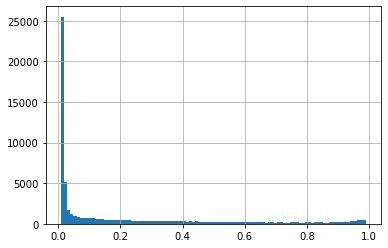

In [5]:
sub1['toxic'].hist(bins=100)

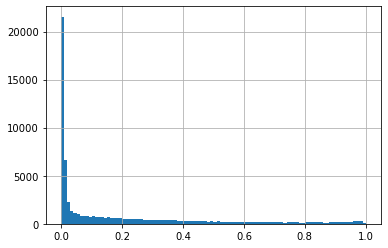

In [6]:
sub2['toxic'].hist(bins=100)

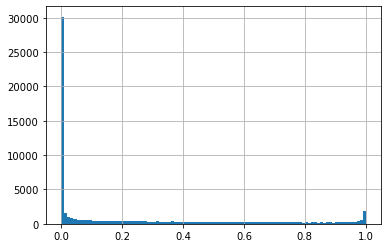

In [7]:
sub3['toxic'].hist(bins=100)

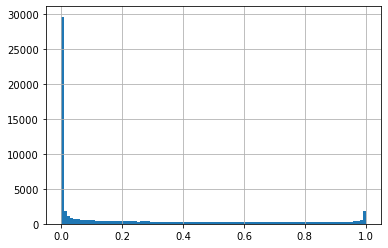

In [8]:
sub4['toxic'].hist(bins=100)

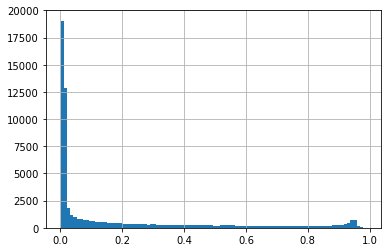

In [9]:
sub5['toxic'].hist(bins=100)

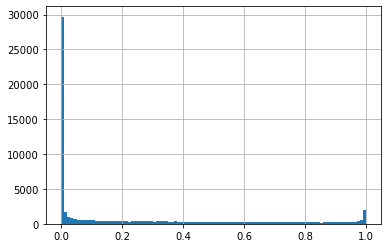

In [10]:
sub6['toxic'].hist(bins=100)

In [11]:
corr = np.zeros((6,6))
submissions = [sub1.toxic.values, sub2.toxic.values, sub3.toxic.values, sub4.toxic.values, sub5.toxic.values, sub6.toxic.values]
for i, s1 in enumerate(submissions):
    for j, s2 in enumerate(submissions):
        coef, _ = spearmanr(s1,s2)
        corr[i,j] = coef
        
corr = pd.DataFrame(corr)
corr.columns = [f'sub{i+1}' for i in range(6)]
corr.index = corr.columns

In [12]:
corr

,sub1,sub2,sub3,sub4,sub5,sub6
sub1,1.000000,0.977697,0.970259,0.943320,0.943891,0.964028
sub2,0.977697,1.000000,0.968478,0.953015,0.942854,0.964354
sub3,0.970259,0.968478,1.000000,0.983361,0.920320,0.992680
sub4,0.943320,0.953015,0.983361,1.000000,0.907029,0.987725
sub5,0.943891,0.942854,0.920320,0.907029,1.000000,0.913186
sub6,0.964028,0.964354,0.992680,0.987725,0.913186,1.000000


### Blending

In [13]:
from scipy.stats import rankdata

def ensemble_predictions(predictions, weights, type_="linear"):
    assert np.isclose(np.sum(weights), 1.0)
    if type_ == "linear":
        res = np.average(predictions, weights=weights, axis=0)
    elif type_ == "harmonic":
        res = np.average([1 / p for p in predictions], weights=weights, axis=0)
        return 1 / res
    elif type_ == "geometric":
        numerator = np.average(
            [np.log(p) for p in predictions], weights=weights, axis=0
        )
        res = np.exp(numerator / sum(weights))
        return res
    elif type_ == "rank":
        res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
        return res / (len(res) + 1)
    return res

In [14]:
weights = [0.329, 0.12, 0.072, 0.24, 0.071, 0.168]
#weights = weights / np.sum(weights)

In [15]:
print(np.sum(weights))

1.0


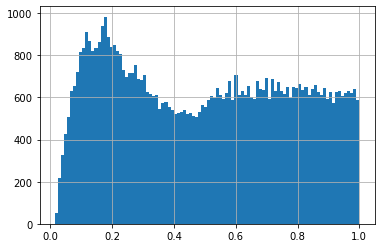

In [16]:
sub1["toxic"] = ensemble_predictions(
    [sub1['toxic'].values, sub2['toxic'].values,sub3['toxic'].values, sub4['toxic'].values, sub5['toxic'].values, sub6['toxic'].values],
    weights,
    type_="rank",
)

sub1['toxic'].hist(bins=100)

In [17]:
test_df=pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [18]:
test_df['toxic']=sub1['toxic']

In [19]:
test_df.loc[test_df["lang"] == "es", "toxic"] *= 1.06
test_df.loc[test_df["lang"] == "fr", "toxic"] *= 1.04
test_df.loc[test_df["lang"] == "it", "toxic"] *= 0.97
test_df.loc[test_df["lang"] == "pt", "toxic"] *= 0.96
test_df.loc[test_df["lang"] == "tr", "toxic"] *= 0.98

In [20]:
sub1['toxic']=test_df['toxic']

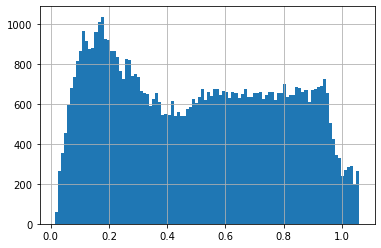

In [21]:
sub1['toxic'].hist(bins=100)

In [22]:
sub1.to_csv('submission.csv', index=False)